<a href="https://colab.research.google.com/github/SajalDasShovon/Credit_Card_Fraud_Detection_ML_Project/blob/main/credit_card_fraud_notebook_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Credit card fraud is a growing global concern that costs financial institutions and consumers billions of dollars each year. Our project is motivated by the need to overcome this limitation and develop a system that can reliably detect fraudulent transactions while keeping false alarms low.

In [ ]:
##################################################
# install extra dependencies
##################################################
!pip -q install scipy==1.12.0 imbalanced-learn shap xgboost scikit-plot
!pip install -U numpy==1.26.4 pandas matplotlib seaborn scikit-learn scipy xgboost tensorflow imbalanced-learn shap scikit-plot --force-reinstall


  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.0 MB/s eta 0:00:00
  Using cached scikit_plot-0.3.7-py3-none-any.whl.metadata (7.1 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 6.1 MB/s eta 0:00:00
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 155.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [ ]:
# ##################################################
# 1) Import necessary libraries & dependencies
####################################################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, time, io, os


import scipy
scipy.interp = np.interp
import scikitplot as skplt

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.style.use("ggplot")
np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.float_format", "{:.6f}".format)

from google.colab import files

# sklearn & dependencies
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score, precision_score, recall_score,
    f1_score, matthews_corrcoef, brier_score_loss
)
from sklearn.calibration import calibration_curve
from sklearn.utils.class_weight import compute_class_weight

# Import Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier

#  for handling Data imbalance
from imblearn.over_sampling import SMOTE

# for Deep learning model
import tensorflow as tf
from tensorflow.keras import layers, models

# for Interpretability chekcing
import shap



ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

**Data import & preprocessing**

In [ ]:
# ##################################################
# 2) Data importing
# ##################################################

data_path = "/content/drive/MyDrive/creditcard.csv"

#csv_name = list(uploaded.keys())[0]
df = pd.read_csv(data_path)

print("Shape:", df.shape)
display(df.head())
display(df.describe())
print("\nMissing values per column:")
display(df.isnull().sum())
assert "Class" in df.columns, "Dataset must include a 'Class' column."



Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.620000,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,1.000000,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660000,0
3,1.000000,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,2.000000,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.990000,0


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,...,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000,284807.000000
mean,94813.859575,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,...,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,88.349619,0.001727
std,47488.145955,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,...,0.734524,0.725702,0.624460,0.605647,0.521278,0.482227,0.403632,0.330083,250.120109,0.041527
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54201.500000,-0.920373,-0.598550,-0.890365,-0.848640,-0.691597,-0.768296,-0.554076,-0.208630,-0.643098,...,-0.228395,-0.542350,-0.161846,-0.354586,-0.317145,-0.326984,-0.070840,-0.052960,5.600000,0.000000
50%,84692.000000,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,...,-0.029450,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,22.000000,0.000000
75%,139320.500000,1.315642,0.803724,1.027196,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,...,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.091045,0.078280,77.165000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000



Missing values per column:


,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


**Exploratory Data Analysis**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Class Distribution:
 Class
0    284315
1       492
Name: count, dtype: int64
Fraud Percentage: 0.1727%


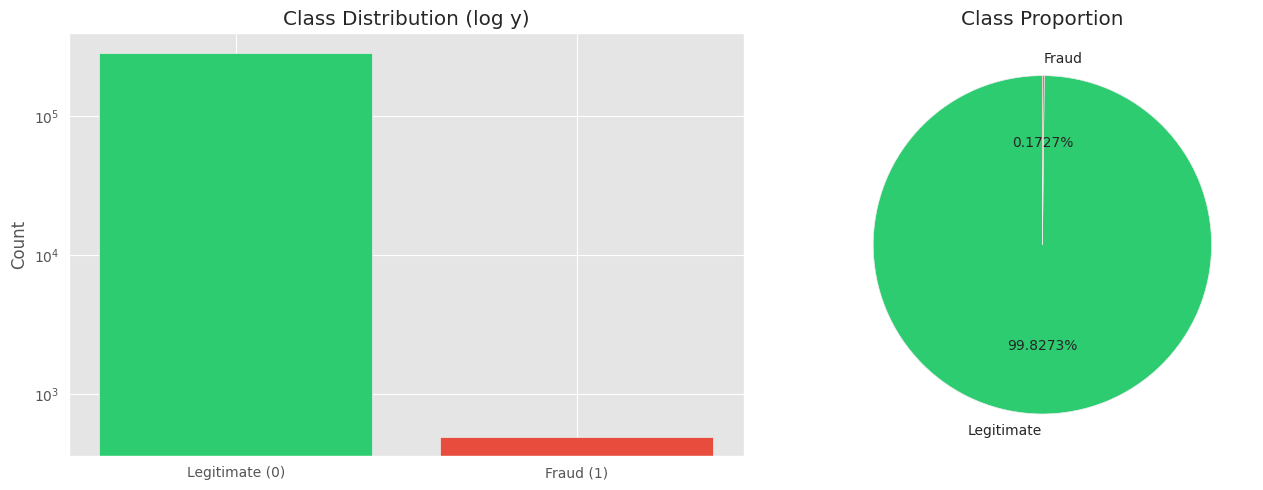

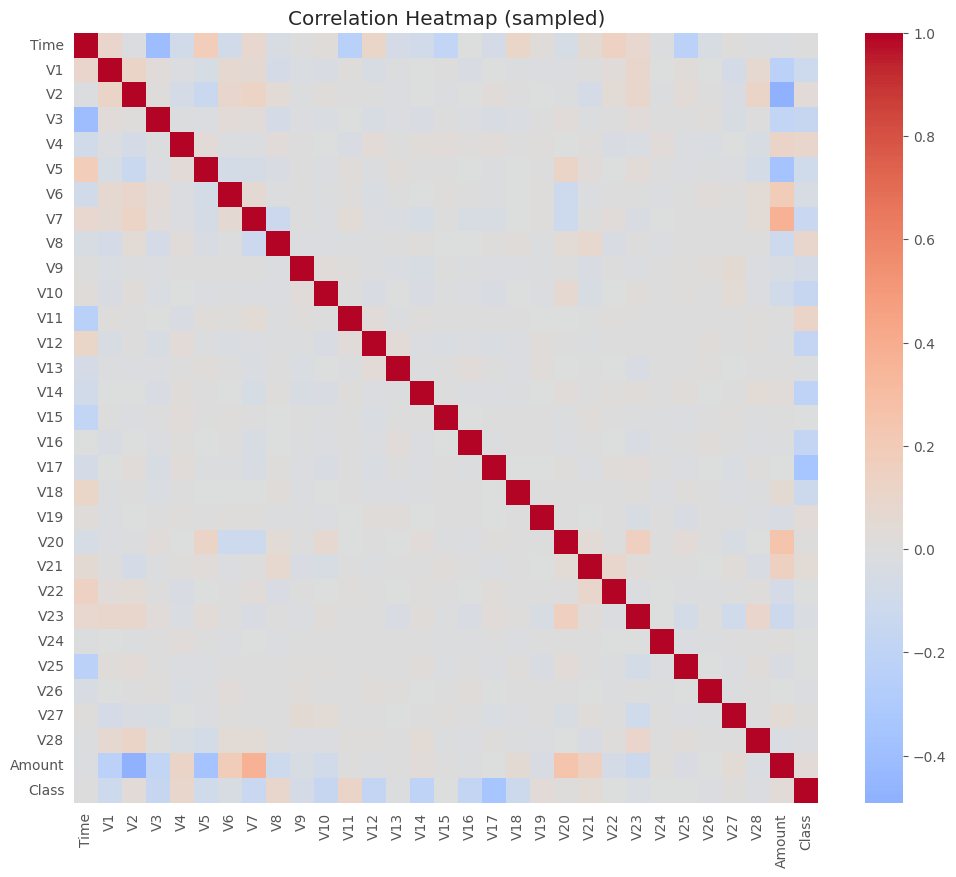

In [ ]:
# ##################################################
# 3) Class imbalance & Basic inspection
# ##################################################
class_counts = df["Class"].value_counts().sort_index()
print("Class Distribution:\n", class_counts)
fraud_rate = 100 * class_counts.get(1, 0) / len(df)
print(f"Fraud Percentage: {fraud_rate:.4f}%")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar (log scale helps show minority)
axes[0].bar(["Legitimate (0)", "Fraud (1)"], [class_counts.get(0,0), class_counts.get(1,0)],
            color=["#2ecc71", "#e74c3c"])
axes[0].set_yscale("log")
axes[0].set_title("Class Distribution (log y)")
axes[0].set_ylabel("Count")

# Pie
axes[1].pie([class_counts.get(0,0), class_counts.get(1,0)],
            labels=["Legitimate", "Fraud"], autopct="%1.4f%%",
            colors=["#2ecc71", "#e74c3c"], startangle=90)
axes[1].set_title("Class Proportion")

plt.tight_layout(); plt.show()

# Correlation heatmap for a quick look (optional: sample to speed)
sample_for_corr = df.sample(min(8000, len(df)), random_state=42)
corr = sample_for_corr.corr(numeric_only=True)
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (sampled)"); plt.show()


**Dataset Overview:**

* Number of transactions: 284,807
* Number of fraudulent transactions: 492
* Fraud ratio ~0.172% (highly imbalanced dataset)
*Time period: 2 days

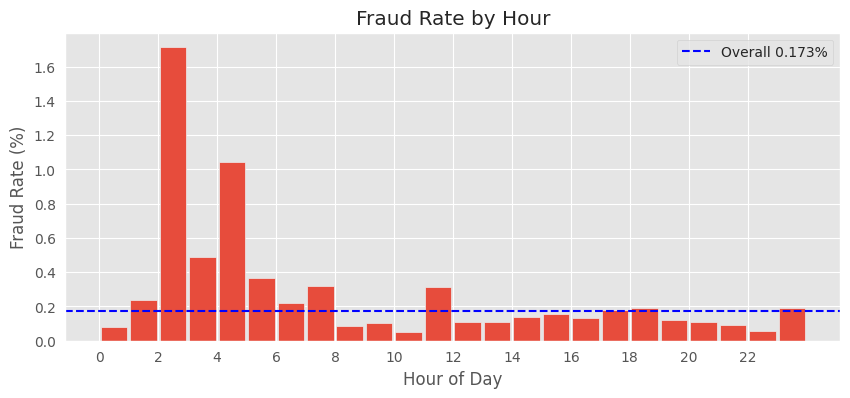

In [ ]:
# ##################################################
# 4) Temporal Amalysis
# ##################################################
if "Time" in df.columns:
    # Simple temporal fraud rate by hour-of-day (assuming seconds since start)
    hours = (df["Time"] / 3600) % 24
    tmp = pd.DataFrame({"hour": hours, "Class": df["Class"]})
    bins = np.arange(0, 25)
    legit_hist, _ = np.histogram(tmp[tmp["Class"]==0]["hour"], bins=bins)
    fraud_hist, _ = np.histogram(tmp[tmp["Class"]==1]["hour"], bins=bins)
    rate = fraud_hist / (fraud_hist + legit_hist + 1e-12)

    plt.figure(figsize=(10, 4))
    plt.bar(bins[:-1]+0.5, 100*rate, width=0.9, color="#e74c3c")
    plt.axhline(100*fraud_rate/100, ls="--", c="blue", label=f"Overall {fraud_rate:.3f}%")
    plt.xticks(range(0,24,2)); plt.xlabel("Hour of Day"); plt.ylabel("Fraud Rate (%)")
    plt.title("Fraud Rate by Hour"); plt.legend(); plt.show()


As mentioned in the project proposal, the dataset is highly imbalanced. The following shows the class distribution, where only 0.172% (492 values) of the transactions are fraudulent.

=== Daywise Fraud Summary ===


,Day,total_transactions,fraud_transactions,fraud_percent
0,1,144786,281,0.194080
1,2,140021,211,0.150692


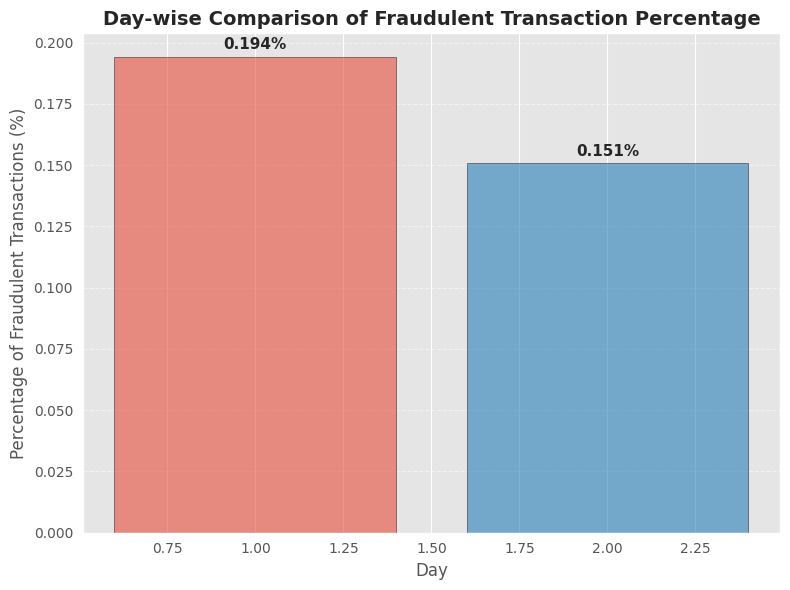

Day 1: 281 fraud / 144786 total (0.1941%)
Day 2: 211 fraud / 140021 total (0.1507%)


In [ ]:
# ##################################################
# 4.1) Day 1 vs Day 2 Fraud Comparison
# ##################################################
df["Day"] = np.floor(df["Time"] / (24 * 3600)).astype(int) + 1  # Day 1, Day 2

# Compute total and fraudulent transactions per day
day_summary = (
    df.groupby("Day")["Class"]
      .agg(total_transactions="count",
           fraud_transactions=lambda x: (x == 1).sum())
      .reset_index()
)
day_summary["fraud_percent"] = (
    100 * day_summary["fraud_transactions"] / day_summary["total_transactions"]
)

print("=== Daywise Fraud Summary ===")
display(day_summary)

# Plot Day-wise comparison
fig, ax = plt.subplots(figsize=(8, 6))

# Bar plot of fraud percentages
bars = ax.bar(day_summary["Day"],
              day_summary["fraud_percent"],
              color=["#E74C3C", "#2980B9", "#27AE60", "#AF7AC5"][:len(day_summary)],
              alpha=0.6, edgecolor="black")

# Annotate each bar with percentage values
for bar, pct in zip(bars, day_summary["fraud_percent"]):
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.002,
            f"{pct:.3f}%",
            ha="center", va="bottom", fontsize=11, fontweight="bold")

# Labels & Title
ax.set_xlabel("Day", fontsize=12)
ax.set_ylabel("Percentage of Fraudulent Transactions (%)", fontsize=12)
ax.set_title("Day-wise Comparison of Fraudulent Transaction Percentage",
             fontsize=14, fontweight="bold")
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig("fraud_comparison_daywise.png", dpi=300, bbox_inches="tight")
plt.show()

# Print summary
for _, row in day_summary.iterrows():
    print(f"Day {int(row['Day'])}: {int(row['fraud_transactions'])} fraud / "
          f"{int(row['total_transactions'])} total "
          f"({row['fraud_percent']:.4f}%)")


let's check how well fraud and legitimate transactions are separable based on their features with PCA & t-SNE

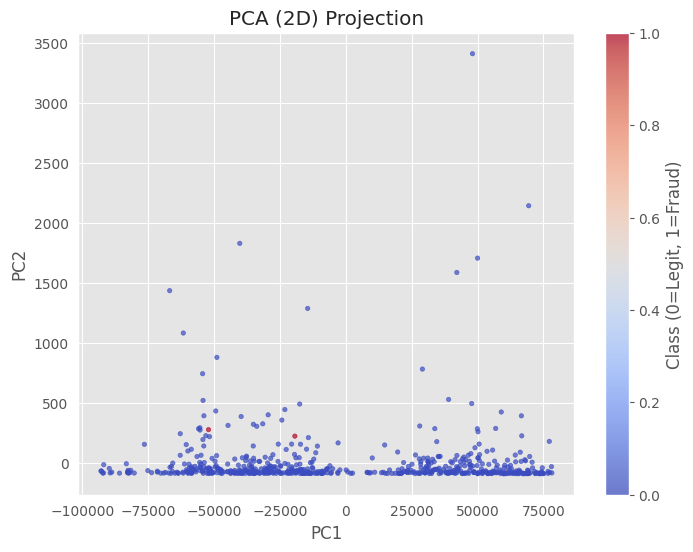

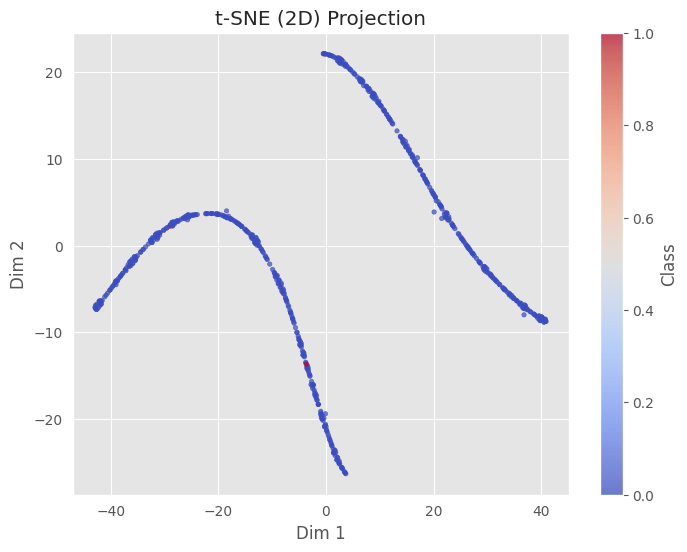

In [ ]:
# ##################################################
# 5) PCA & t-SNE (Separability check)
# ##################################################
X_all = df.drop("Class", axis=1).values
y_all = df["Class"].values

np.random.seed(42)
idx = np.random.choice(len(X_all), size=min(600, len(X_all)), replace=False)
X_vis = X_all[idx]
y_vis = y_all[idx]

# PCA
pca = PCA(n_components=2, random_state=42)
pca_2d = pca.fit_transform(X_vis)
plt.figure(figsize=(8,6))
plt.scatter(pca_2d[:,0], pca_2d[:,1], c=y_vis, cmap="coolwarm", s=10, alpha=0.7)
plt.title("PCA (2D) Projection"); plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(label="Class (0=Legit, 1=Fraud)"); plt.show()

# t-SNE
tsne = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto")
tsne_2d = tsne.fit_transform(X_vis)
plt.figure(figsize=(8,6))
plt.scatter(tsne_2d[:,0], tsne_2d[:,1], c=y_vis, cmap="coolwarm", s=10, alpha=0.7)
plt.title("t-SNE (2D) Projection"); plt.xlabel("Dim 1"); plt.ylabel("Dim 2")
plt.colorbar(label="Class"); plt.show()


**Train-test split**

In [ ]:
# ##################################################
# 6) SPLIT → SCALE → (LATER) RESAMPLE (NO LEAKAGE)
# ##################################################
# drop rows where 'Class' is null
df.dropna(subset=["Class"], inplace=True)

X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns=X_test.columns,  index=X_test.index)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("\nTrain class distribution:\n", y_train.value_counts())
print("\nTest class distribution:\n", y_test.value_counts())

Train size: (204384, 30)  Test size: (51097, 30)

Train class distribution:
 Class
0.000000    204009
1.000000       375
Name: count, dtype: int64

Test class distribution:
 Class
0.000000    51003
1.000000       94
Name: count, dtype: int64


In [ ]:
# ======================================================================
# 7) RESAMPLING VARIANTS (TRAIN ONLY): SMOTE + UNDERSAMPLE
# ======================================================================
# SMOTE oversampling
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train_scaled, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", pd.Series(y_train_smote).value_counts())

# Undersampling majority to minority count
X_maj = X_train_scaled[y_train==0]
y_maj = y_train[y_train==0]
X_min = X_train_scaled[y_train==1]
y_min = y_train[y_train==1]

np.random.seed(42)
sel_idx = np.random.choice(X_maj.index, size=len(X_min), replace=False)
X_train_under = pd.concat([X_maj.loc[sel_idx], X_min], axis=0)
y_train_under = pd.concat([y_maj.loc[sel_idx], y_min], axis=0)

print("\nAfter undersampling:\n", y_train_under.value_counts())


Before SMOTE:
 Class
0.000000    204009
1.000000       375
Name: count, dtype: int64

After SMOTE:
 Class
0.000000    204009
1.000000    204009
Name: count, dtype: int64

After undersampling:
 Class
0.000000    375
1.000000    375
Name: count, dtype: int64


In [ ]:
# ======================================================================
# 8) EVALUATION UTILITIES
#    - assess_model(): trains & reports metrics + confusion heatmap (optional)
#    - plot_roc_pr(): ROC + PR curves
#    - threshold_sweep(): search threshold maximizing F-beta or Youden J
# ======================================================================
def assess_model(model, X_tr, y_tr, X_te, y_te, name, plot_matrix=True, verbose=True):
    start = time.perf_counter()
    model.fit(X_tr, y_tr)
    runtime = time.perf_counter() - start

    # probs
    y_prob = None
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_te)[:, 1]
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_te)
        smin, smax = scores.min(), scores.max()
        y_prob = (scores - smin) / (smax - smin + 1e-12)

    # preds (0.5 threshold if proba exists, else direct predict)
    if y_prob is not None:
        y_pred = (y_prob >= 0.5).astype(int)
    else:
        y_pred = model.predict(X_te)

    # metrics
    precision = precision_score(y_te, y_pred, zero_division=0)
    recall    = recall_score(y_te, y_pred, zero_division=0)
    f1        = f1_score(y_te, y_pred, zero_division=0)
    mcc       = matthews_corrcoef(y_te, y_pred)
    auc       = roc_auc_score(y_te, y_prob) if y_prob is not None else np.nan
    brier     = brier_score_loss(y_te, y_prob) if y_prob is not None else np.nan

    if verbose:
        print(f"\n{name} — Training time: {runtime:.3f} sec")
        print("Classification Report:\n", classification_report(y_te, y_pred, digits=4))
        print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | MCC: {mcc:.4f} | AUC: {auc:.4f} | Brier: {brier:.5f}")

    cm = confusion_matrix(y_te, y_pred, labels=[1,0])
    if plot_matrix:
        plt.figure(figsize=(6, 4))
        sns.heatmap(
            cm, annot=True, fmt="d", cmap="RdYlGn_r",
            xticklabels=["Fraud (1)", "Legit (0)"],
            yticklabels=["Fraud (1)", "Legit (0)"],
            cbar=False, linewidths=1, linecolor="white"
        )
        plt.title(f"Confusion Matrix — {name}")
        plt.ylabel("True Label"); plt.xlabel("Predicted Label")
        plt.tight_layout(); plt.show()

    return {
        "model": model,
        "y_pred": y_pred,
        "y_prob": y_prob,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "mcc": mcc,
        "auc": auc,
        "brier": brier,
        "confusion_matrix": cm,
        "time": runtime
    }

def plot_roc_pr(results_dict, y_true, title_suffix=""):
    # ROC
    plt.figure(figsize=(8,6))
    for name, res in results_dict.items():
        y_prob = res["y_prob"]
        if y_prob is None:
            continue
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={res['auc']:.3f})")
    plt.plot([0,1],[0,1],"k--", label="Random")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves {title_suffix}"); plt.legend(); plt.grid(True, alpha=0.3)
    plt.show()

    # Precision–Recall
    plt.figure(figsize=(8,6))
    for name, res in results_dict.items():
        y_prob = res["y_prob"]
        if y_prob is None:
            continue
        prec, rec, _ = precision_recall_curve(y_true, y_prob)
        ap = average_precision_score(y_true, y_prob)
        plt.plot(rec, prec, lw=2, label=f"{name} (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"Precision–Recall Curves {title_suffix}")
    plt.legend(loc="lower left"); plt.grid(True, alpha=0.3)
    plt.show()

def threshold_sweep(y_true, y_prob, name="Model", beta=2.0):
    """Return best threshold by F-beta and Youden's J; plot F-beta vs threshold."""
    thresholds = np.linspace(0, 1, 201)
    fb, j_list = [], []
    for t in thresholds:
        y_hat = (y_prob >= t).astype(int)
        p = precision_score(y_true, y_hat, zero_division=0)
        r = recall_score(y_true, y_hat, zero_division=0)
        fbeta = (1+beta**2)*p*r / (beta**2*p + r) if (p+r)>0 else 0.0
        fb.append(fbeta)
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        # Youden's J is max over ROC points; for t grid we approximate using y_hat confusion
        tn, fp, fn, tp = confusion_matrix(y_true, y_hat).ravel()
        tpr_t = tp / (tp + fn + 1e-12)
        fpr_t = fp / (fp + tn + 1e-12)
        j_list.append(tpr_t - fpr_t)

    best_f_idx = int(np.argmax(fb))
    best_f_t = thresholds[best_f_idx]
    best_j_idx = int(np.argmax(j_list))
    best_j_t = thresholds[best_j_idx]

    plt.figure(figsize=(8,4))
    plt.plot(thresholds, fb, label=f"F{beta} vs threshold", lw=2)
    plt.axvline(best_f_t, ls="--", c="red", label=f"Best F{beta} @ {best_f_t:.3f}")
    plt.xlabel("Threshold"); plt.ylabel(f"F{beta}-Score")
    plt.title(f"{name} — F{beta}-Score vs Threshold")
    plt.legend(); plt.grid(True, alpha=0.3); plt.show()

    print(f"{name} — Best F{beta} threshold: {best_f_t:.3f}, score: {fb[best_f_idx]:.4f}")
    print(f"{name} — Best Youden J threshold: {best_j_t:.3f}, J: {j_list[best_j_idx]:.4f}")
    return best_f_t, best_j_t



LR (plain) — Training time: 0.883 sec
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9992    0.9998    0.9995     51003
         1.0     0.8125    0.5532    0.6582        94

    accuracy                         0.9989     51097
   macro avg     0.9058    0.7765    0.8288     51097
weighted avg     0.9988    0.9989    0.9988     51097

Precision: 0.8125 | Recall: 0.5532 | F1: 0.6582 | MCC: 0.6699 | AUC: 0.9516 | Brier: 0.00093


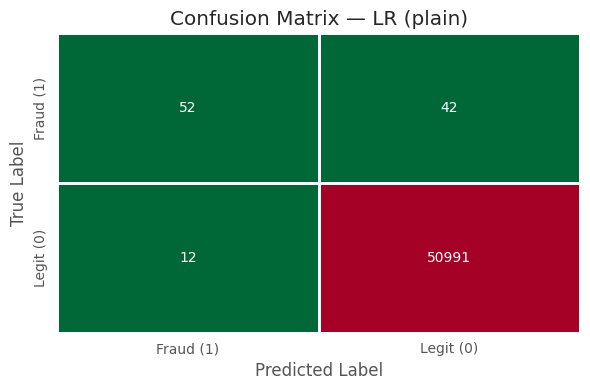


LR (balanced) — Training time: 1.619 sec
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9997    0.9806    0.9901     51003
         1.0     0.0748    0.8511    0.1376        94

    accuracy                         0.9804     51097
   macro avg     0.5373    0.9158    0.5638     51097
weighted avg     0.9980    0.9804    0.9885     51097

Precision: 0.0748 | Recall: 0.8511 | F1: 0.1376 | MCC: 0.2490 | AUC: 0.9625 | Brier: 0.02016


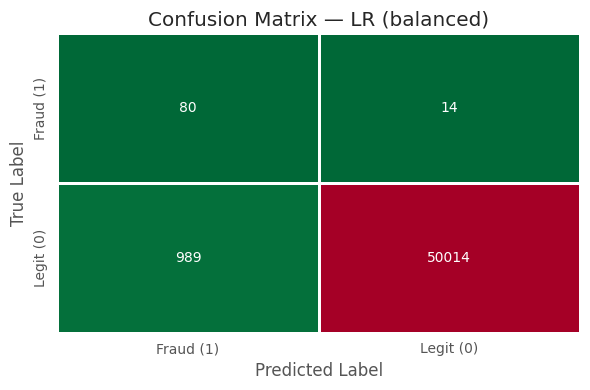


LR (SMOTE) — Training time: 3.239 sec
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9997    0.9782    0.9889     51003
         1.0     0.0679    0.8617    0.1259        94

    accuracy                         0.9780     51097
   macro avg     0.5338    0.9199    0.5574     51097
weighted avg     0.9980    0.9780    0.9873     51097

Precision: 0.0679 | Recall: 0.8617 | F1: 0.1259 | MCC: 0.2383 | AUC: 0.9595 | Brier: 0.02125


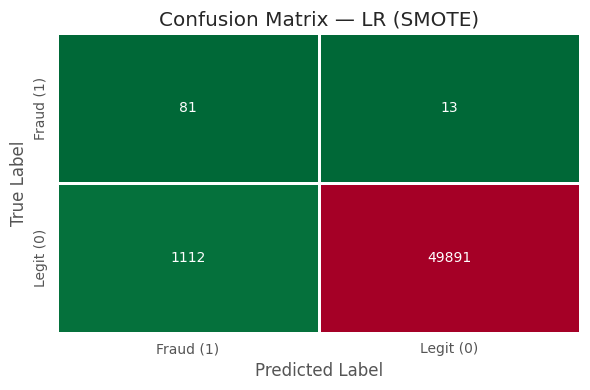


LR (undersampled) — Training time: 0.015 sec
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9997    0.9718    0.9856     51003
         1.0     0.0527    0.8511    0.0993        94

    accuracy                         0.9716     51097
   macro avg     0.5262    0.9114    0.5424     51097
weighted avg     0.9980    0.9716    0.9839     51097

Precision: 0.0527 | Recall: 0.8511 | F1: 0.0993 | MCC: 0.2077 | AUC: 0.9520 | Brier: 0.02629


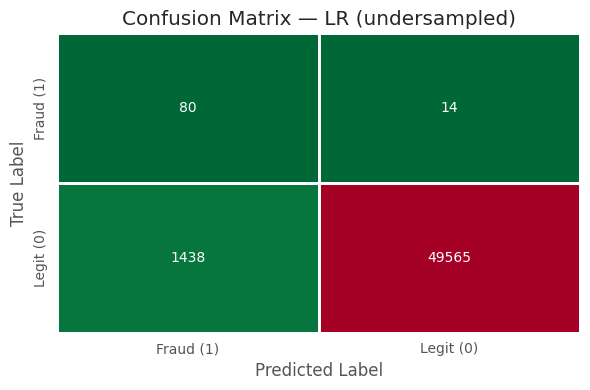


Decision Tree — Training time: 8.253 sec
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9995    1.0000    0.9997     51003
         1.0     0.9718    0.7340    0.8364        94

    accuracy                         0.9995     51097
   macro avg     0.9857    0.8670    0.9180     51097
weighted avg     0.9995    0.9995    0.9994     51097

Precision: 0.9718 | Recall: 0.7340 | F1: 0.8364 | MCC: 0.8444 | AUC: 0.8511 | Brier: 0.00054


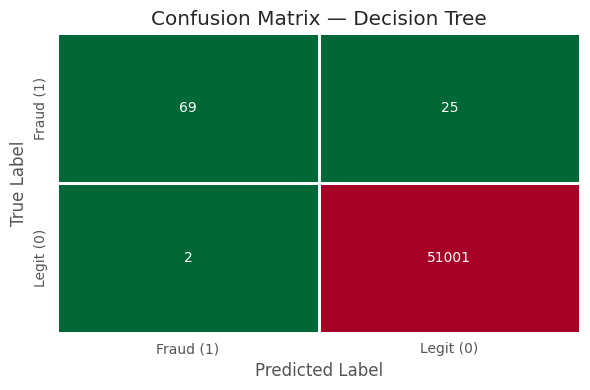


Random Forest — Training time: 496.713 sec
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9995    1.0000    0.9997     51003
         1.0     0.9718    0.7340    0.8364        94

    accuracy                         0.9995     51097
   macro avg     0.9857    0.8670    0.9180     51097
weighted avg     0.9995    0.9995    0.9994     51097

Precision: 0.9718 | Recall: 0.7340 | F1: 0.8364 | MCC: 0.8444 | AUC: 0.9324 | Brier: 0.00053


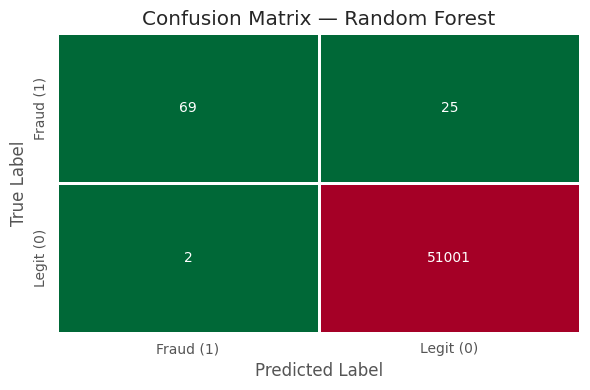


RF (balanced) — Training time: 278.519 sec
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9995    1.0000    0.9997     51003
         1.0     0.9710    0.7128    0.8221        94

    accuracy                         0.9994     51097
   macro avg     0.9852    0.8564    0.9109     51097
weighted avg     0.9994    0.9994    0.9994     51097

Precision: 0.9710 | Recall: 0.7128 | F1: 0.8221 | MCC: 0.8317 | AUC: 0.9275 | Brier: 0.00053


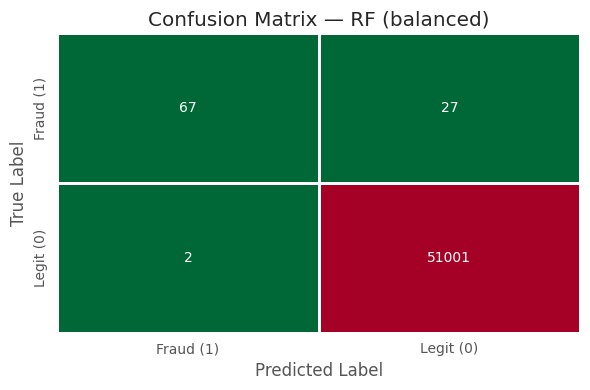


XGBoost — Training time: 11.773 sec
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9996    0.9999    0.9997     51003
         1.0     0.9114    0.7660    0.8324        94

    accuracy                         0.9994     51097
   macro avg     0.9555    0.8829    0.9160     51097
weighted avg     0.9994    0.9994    0.9994     51097

Precision: 0.9114 | Recall: 0.7660 | F1: 0.8324 | MCC: 0.8352 | AUC: 0.9704 | Brier: 0.00050


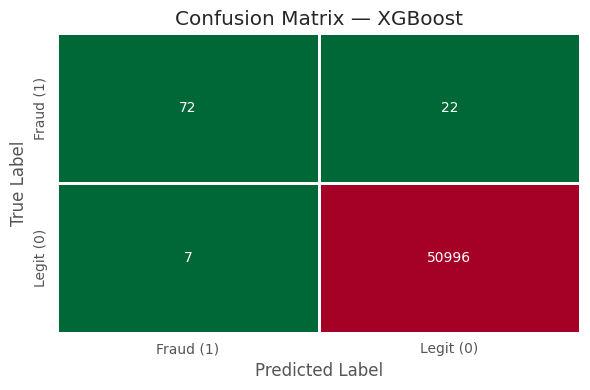

In [ ]:
# ======================================================================
# 9) MODELING — BASELINES & ADVANCED VARIANTS
#     We train on: plain, class_weight, SMOTE, undersampled
# ======================================================================
results = {}

# Logistic Regression
lr_plain = LogisticRegression(random_state=42, max_iter=1000)
results["LR (plain)"] = assess_model(lr_plain, X_train_scaled, y_train, X_test_scaled, y_test, "LR (plain)")

lr_bal = LogisticRegression(class_weight="balanced", random_state=42, max_iter=1000)
results["LR (balanced)"] = assess_model(lr_bal, X_train_scaled, y_train, X_test_scaled, y_test, "LR (balanced)")

lr_sm = LogisticRegression(random_state=42, max_iter=1000)
results["LR (SMOTE)"] = assess_model(lr_sm, X_train_smote, y_train_smote, X_test_scaled, y_test, "LR (SMOTE)")

lr_under = LogisticRegression(random_state=42, max_iter=1000)
results["LR (undersampled)"] = assess_model(lr_under, X_train_under, y_train_under, X_test_scaled, y_test, "LR (undersampled)")

# Decision Tree (simple baseline)
dt = DecisionTreeClassifier(max_depth=6, random_state=42)
results["Decision Tree"] = assess_model(dt, X_train_scaled, y_train, X_test_scaled, y_test, "Decision Tree")

# Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
results["RF"] = assess_model(rf, X_train_scaled, y_train, X_test_scaled, y_test, "Random Forest")

rf_bal = RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42, n_jobs=-1)
results["RF (balanced)"] = assess_model(rf_bal, X_train_scaled, y_train, X_test_scaled, y_test, "RF (balanced)")

# XGBoost (scale_pos_weight)
pos = (y_train==1).sum()
neg = (y_train==0).sum()
spw = neg / max(1, pos)
xgb = XGBClassifier(
    scale_pos_weight=spw,
    max_depth=6, learning_rate=0.1, n_estimators=400,
    subsample=0.9, colsample_bytree=0.9,
    reg_lambda=1.0, random_state=42, n_jobs=-1,
    eval_metric="logloss"
)
results["XGB"] = assess_model(xgb, X_train_scaled, y_train, X_test_scaled, y_test, "XGBoost")


Class weights: {0: np.float64(0.5009190770995398), 1: np.float64(272.512)}
Epoch 1/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - auc: 0.8997 - loss: 0.4361 - val_auc: 0.9854 - val_loss: 0.1745
Epoch 2/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.9914 - loss: 0.1451 - val_auc: 0.9942 - val_loss: 0.1564
Epoch 3/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - auc: 0.9824 - loss: 0.1545 - val_auc: 0.9954 - val_loss: 0.0974
Epoch 4/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.9926 - loss: 0.1159 - val_auc: 0.9934 - val_loss: 0.0731
Epoch 5/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.9885 - loss: 0.1336 - val_auc: 0.9951 - val_loss: 0.0648
Epoch 6/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.9952 - loss: 0.0993 - val_auc: 0.9951 - val_loss: 0.0820
Epoch 7/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - auc: 0.9953 - loss: 0.0939 - val_auc: 0.9970 - val_loss: 0.0726
Epoch 8/12
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - auc: 0.9970 - loss: 0.0812 - val_auc: 0.9973 - val_loss: 0

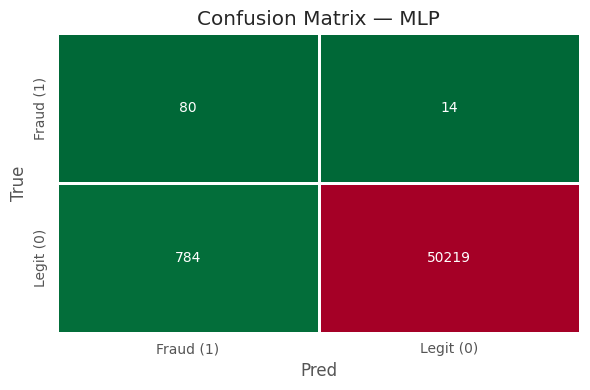

In [ ]:
# ======================================================================
# 10) DEEP LEARNING — MLP with class weights
# ======================================================================
neg, pos = np.bincount(y_train.values.astype(int))
total = neg + pos
w0 = (1/neg)*total/2.0
w1 = (1/pos)*total/2.0
class_weights = {0: w0, 1: w1}
print("Class weights:", class_weights)

mlp = models.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
])
mlp.compile(optimizer="adam", loss="binary_crossentropy", metrics=[tf.keras.metrics.AUC(name="auc")])

start = time.perf_counter()
hist = mlp.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=12, batch_size=2048,
    class_weight=class_weights,
    verbose=1
)
mlp_time = time.perf_counter() - start

y_prob_mlp = mlp.predict(X_test_scaled).ravel()
y_pred_mlp = (y_prob_mlp >= 0.5).astype(int)

prec = precision_score(y_test, y_pred_mlp, zero_division=0)
rec  = recall_score(y_test, y_pred_mlp, zero_division=0)
f1   = f1_score(y_test, y_pred_mlp, zero_division=0)
auc  = roc_auc_score(y_test, y_prob_mlp)
mcc  = matthews_corrcoef(y_test, y_pred_mlp)
brier= brier_score_loss(y_test, y_prob_mlp)
cm   = confusion_matrix(y_test, y_pred_mlp, labels=[1,0])

print(f"\nMLP — Training time: {mlp_time:.3f} sec")
print("Classification Report:\n", classification_report(y_test, y_pred_mlp, digits=4))
print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | MCC: {mcc:.4f} | AUC: {auc:.4f} | Brier: {brier:.5f}")

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="RdYlGn_r",
            xticklabels=["Fraud (1)", "Legit (0)"], yticklabels=["Fraud (1)", "Legit (0)"],
            cbar=False, linewidths=1, linecolor="white")
plt.title("Confusion Matrix — MLP"); plt.ylabel("True"); plt.xlabel("Pred")
plt.tight_layout(); plt.show()

results["MLP"] = {
    "model": mlp, "y_pred": y_pred_mlp, "y_prob": y_prob_mlp,
    "precision": prec, "recall": rec, "f1": f1, "mcc": mcc, "auc": auc,
    "brier": brier, "confusion_matrix": cm, "time": mlp_time
}

In [ ]:
# ======================================================================
# 11) MODEL COMPARISON TABLE
# ======================================================================
rows = []
for name, res in results.items():
    rows.append({
        "Model": name,
        "Precision": res["precision"],
        "Recall": res["recall"],
        "F1": res["f1"],
        "MCC": res["mcc"],
        "ROC-AUC": res["auc"],
        "Brier": res["brier"],
        "Train Time (s)": res["time"]
    })
summary_df = pd.DataFrame(rows).sort_values(by=["F1","ROC-AUC"], ascending=False)
display(summary_df)


,Model,Precision,Recall,F1,MCC,ROC-AUC,Brier,Train Time (s)
5,RF,0.971831,0.734043,0.836364,0.844374,0.932440,0.000525,496.713305
4,Decision Tree,0.971831,0.734043,0.836364,0.844374,0.851148,0.000536,8.253193
7,XGB,0.911392,0.765957,0.832370,0.835244,0.970358,0.000504,11.772620
6,RF (balanced),0.971014,0.712766,0.822086,0.831680,0.927482,0.000529,278.518612
0,LR (plain),0.812500,0.553191,0.658228,0.669942,0.951618,0.000928,0.882687
8,MLP,0.092593,0.851064,0.167015,0.277752,0.943364,0.012369,22.747234
1,LR (balanced),0.074836,0.851064,0.137575,0.249011,0.962528,0.020164,1.619251
2,LR (SMOTE),0.067896,0.861702,0.125874,0.238342,0.959467,0.021254,3.238899
3,LR (undersampled),0.052701,0.851064,0.099256,0.207686,0.951977,0.026292,0.015348


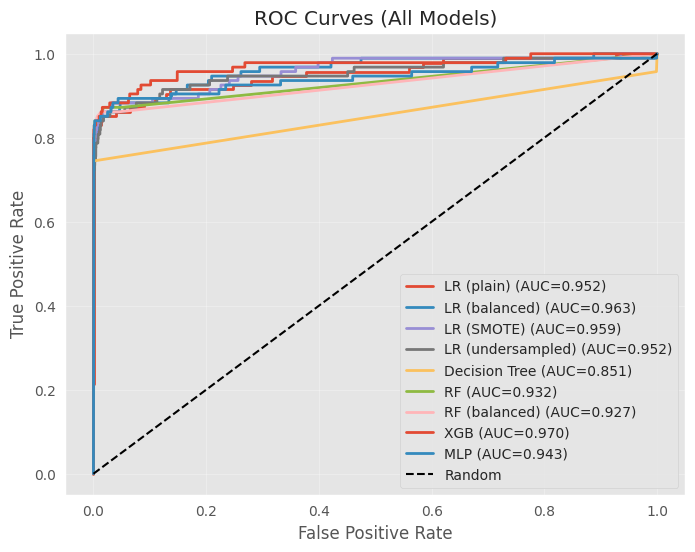

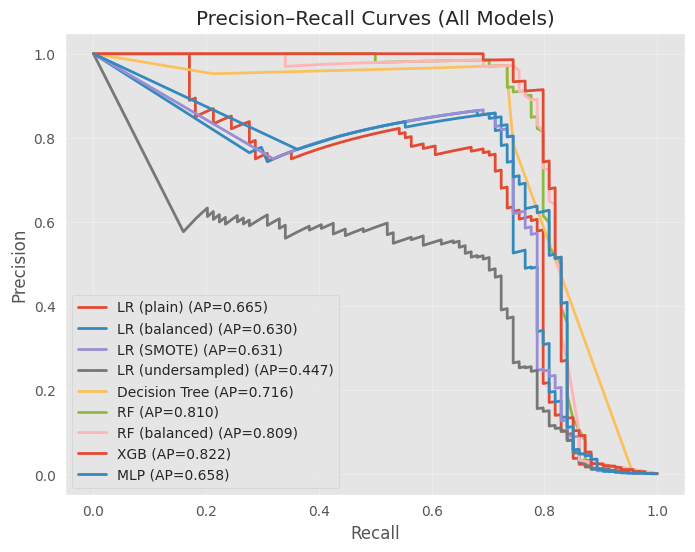

In [ ]:
# ======================================================================
# 12) ROC & PR CURVES (ALL MODELS)
# ======================================================================
plot_roc_pr(results, y_test, title_suffix="(All Models)")


In [ ]:
# ======================================================================
# 13) CALIBRATION CURVE + KS / LIFT / CUMULATIVE GAINS (example model)
#      Pick a strong probabilistic model (e.g., XGB or RF balanced)
# ======================================================================
chosen = "XGB" if "XGB" in results else list(results.keys())[0]
print("Calibration & Gains for:", chosen)
yp = results[chosen]["y_prob"]

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, yp, n_bins=10, strategy="quantile")
plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker="o", lw=2, label="Calibrated")
plt.plot([0,1],[0,1],"k--", label="Perfect")
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title(f"Calibration Curve — {chosen}")
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

# KS statistic
skplt.metrics.plot_ks_statistic(y_test, np.column_stack([1-yp, yp]))
plt.title(f"KS Statistic — {chosen}")
plt.show()

# Cumulative gain & Lift
skplt.metrics.plot_cumulative_gain(y_test, np.column_stack([1-yp, yp]))
plt.title(f"Cumulative Gain — {chosen}")
plt.show()

skplt.metrics.plot_lift_curve(y_test, np.column_stack([1-yp, yp]))
plt.title(f"Lift Curve — {chosen}")
plt.show()

NameError: name 'results' is not defined

Threshold tuning on: XGB


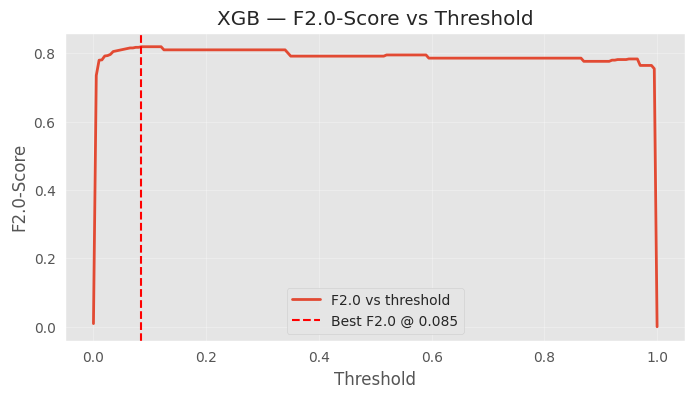

XGB — Best F2.0 threshold: 0.085, score: 0.8188
XGB — Best Youden J threshold: 0.010, J: 0.8183

Re-evaluation @ threshold = 0.085
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9996    0.9999    0.9997     51003
         1.0     0.9146    0.7979    0.8523        94

    accuracy                         0.9995     51097
   macro avg     0.9571    0.8989    0.9260     51097
weighted avg     0.9995    0.9995    0.9995     51097



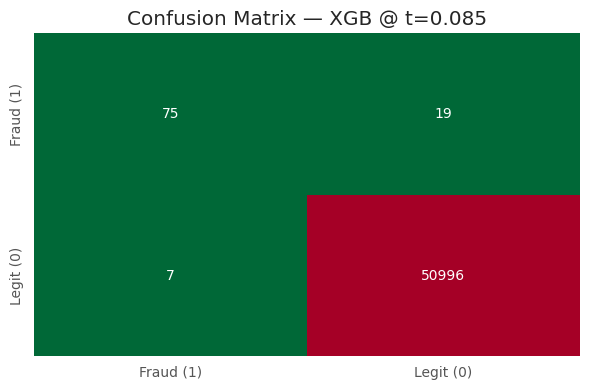

In [ ]:
# ======================================================================
# 14) THRESHOLD SWEEP — FIND BETTER OPERATING POINT (e.g., F2)
# ======================================================================
target_model = "XGB" if "XGB" in results else "RF (balanced)"
print("Threshold tuning on:", target_model)
best_f2_t, best_j_t = threshold_sweep(y_test, results[target_model]["y_prob"], name=target_model, beta=2.0)

# Apply best F2 threshold and re-evaluate
t = best_f2_t
y_hat_opt = (results[target_model]["y_prob"] >= t).astype(int)
print("\nRe-evaluation @ threshold =", round(t,3))
print("Classification Report:\n", classification_report(y_test, y_hat_opt, digits=4))
cm_opt = confusion_matrix(y_test, y_hat_opt, labels=[1,0])
plt.figure(figsize=(6,4))
sns.heatmap(cm_opt, annot=True, fmt="d", cmap="RdYlGn_r",
            xticklabels=["Fraud (1)", "Legit (0)"], yticklabels=["Fraud (1)", "Legit (0)"],
            cbar=False)
plt.title(f"Confusion Matrix — {target_model} @ t={t:.3f}")
plt.tight_layout(); plt.show()


In [ ]:
# ======================================================================
# 15) FEATURE IMPORTANCE (RF & XGB) + TOP FEATURES
# ======================================================================
if "RF (balanced)" in results:
    rf_model = results["RF (balanced)"]["model"]
    imp = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print("\nRandom Forest (balanced) — Top 15 features:")
    display(imp.head(15))

if "XGB" in results:
    xgb_model = results["XGB"]["model"]
    imp = pd.Series(xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print("\nXGBoost — Top 15 features:")
    display(imp.head(15))



Random Forest (balanced) — Top 15 features:


,0
V14,0.159086
V10,0.130546
V12,0.108779
V4,0.108706
V17,0.081559
V11,0.074516
V16,0.058533
V3,0.052483
V2,0.028310
V7,0.026199



XGBoost — Top 15 features:


,0
V14,0.474297
V12,0.129152
V4,0.054539
V10,0.049439
V17,0.027373
V8,0.025322
V3,0.021808
Amount,0.020754
V21,0.018295
V20,0.018238


In [ ]:
# ======================================================================
# 16) SHAP INTERPRETABILITY (RF balanced & XGB) — subset for speed
# ======================================================================
subset = min(3000, len(X_test_scaled))
X_shap = X_test_scaled.iloc[:subset]
X_shap_np = X_shap.values # Convert to numpy array for shap_values calculation
y_shap = y_test.iloc[:subset]

# RF (balanced)
if "RF (balanced)" in results:
    try:
        expl_rf = shap.TreeExplainer(results["RF (balanced)"]["model"])
        # Pass numpy array to shap_values calculation
        shap_vals_rf = expl_rf.shap_values(X_shap_np)
        # Use DataFrame for plotting to retain feature names
        shap.summary_plot(shap_vals_rf[1], X_shap, plot_type="bar", show=True)
        shap.summary_plot(shap_vals_rf[1], X_shap, show=True)
    except Exception as e:
        print("SHAP RF failed:", e)

# XGB
if "XGB" in results:
    try:
        expl_xgb = shap.TreeExplainer(results["XGB"]["model"])
        # Pass numpy array to shap_values calculation
        shap_vals_xgb = expl_xgb.shap_values(X_shap_np)
        # Use DataFrame for plotting to retain feature names
        shap.summary_plot(shap_vals_xgb, X_shap, plot_type="bar", show=True)
        shap.summary_plot(shap_vals_xgb, X_shap, show=True)
    except Exception as e:
        print("SHAP XGB failed:", e)


NameError: name 'X_test_scaled' is not defined

In [ ]:
# ======================================================================
# 17) SAVE SUMMARY
# ======================================================================
summary_df.to_csv("model_comparison_summary.csv", index=False)
print("Saved: model_comparison_summary.csv")


Saved: model_comparison_summary.csv
